In [20]:
import pathlib
import scipy.constants
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from fytok.Tokamak import Tokamak
from fytok.modules.CoreProfiles import CoreProfiles
from fytok.modules.Equilibrium import Equilibrium
from spdm.view import View as sp_view
from spdm.data.Path import Path
from spdm.data.Function import Function

data_path = pathlib.Path("/home/salmon/workspace/fytok_data/data/15MA inductive - burn")

astra_profiles = pd.read_excel(
    next(data_path.glob("*ASTRA.xls")).absolute().as_posix(), sheet_name=1, header=10, usecols="B:BN"
)

In [21]:
core_profiles_astra = CoreProfiles(
    f"file+iterprofiles://{next(data_path.glob('*ASTRA.xls')).absolute().as_posix()}#core_profiles"
)

core_profiles_1d_astra = core_profiles_astra.time_slice.current.profiles_1d

equilibrium_astra = Equilibrium(f"file+geqdsk://{next(data_path.glob('**/g*.txt')).absolute().as_posix()}#equilibrium")


2024-01-15 19:41:00,846 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 
2024-01-15 19:41:00,869 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.FyEqAnalyze 


In [22]:
tokamak = Tokamak(
    f"file+iterprofiles://{next(data_path.glob('*ASTRA.xls')).absolute().as_posix()}",
    f"file+geqdsk://{next(data_path.glob('**/g*.txt')).absolute().as_posix()}",
    device="iter",
    shot=900003,
    equilibrium={"code": {"parameters": {"psi_norm": np.linspace(0.0001, 0.999, 128)}}},
    core_transport={
        "model": [
            {"code": {"name": "dummy"}},
            # {"code": {"name": "fast_alpha"}},
        ]
    },
    core_sources={
        "source": [
            {"code": {"name": "dummy"}},
            {"code": {"name": "collisional_equipartition"}},
            {"code": {"name": "fusion", "parameters": {"fusion_reactions": ["D(t,n)alpha"]}}},
            {"code": {"name": "radiation"}},
            {"code": {"name": "synchrotron_radiation"}},
        ]
    },
    transport_solver={
        "code": {
            "name": "fy_trans",
            "parameters": {
                "rho_tor_norm": np.linspace(0.01, 0.99, 128),
                "hyper_diff": 1.0e-5,
                "max_nodes": 512,
                "bc_tol": 1,
                "verbose": 2,
                "units": {
                    "*/density": 1.0e21,
                    "*/density_flux": 1.0e24,
                    "ion/alpha/density": 1.0e18,
                    "ion/alpha/density_flux": 1.0e21,
                    "*/temperature": 1.0e6,
                    "*/temperature_flux": 1.0e27,
                },
            },
        },
        "ion_thermal": ["D", "T", "He"],  #
        "ion_non_thermal": ["alpha"],
        "impurities": ["Ar", "Be"],
        "boundary_condition_type": {
            # fmt: off
            # psi                          at axis \frac{d\psi}{dx}=0  , at boundary \psi=?
            "psi"                       : 1, 
            # density                      at axis \Gamma_s=0          , at boundary n=?
            "*/density"                 : 1, 
            # temperatur                   at axis \frac{dT}{dx}=0     , at boundary T=?
            "*/temperature"             : 1,
            # fmt: on
        },
    },
)

In [23]:
tokamak.initialize()

2024-01-15 19:41:00,991 [    spdm]     INFO: Initialize module fytok.modules.CoreProfiles 
2024-01-15 19:41:00,999 [    spdm]     INFO: Initialize module fytok.plugins.equilibrium.FyEqAnalyze 
2024-01-15 19:41:01,005 [    spdm]     INFO: Initialize module fytok.modules.Wall 
2024-01-15 19:41:01,009 [    spdm]     INFO: Initialize module fytok.modules.TF 
2024-01-15 19:41:01,014 [    spdm]     INFO: Initialize module fytok.modules.Magnetics 
2024-01-15 19:41:01,019 [    spdm]     INFO: Initialize module fytok.modules.PFActive 
2024-01-15 19:41:01,024 [    spdm]     INFO: Initialize module fytok.modules.CoreSources 
2024-01-15 19:41:01,031 [    spdm]     INFO: Initialize module fytok.plugins.core_sources.source.dummy 
2024-01-15 19:41:01,036 [    spdm]     INFO: Initialize module fytok.plugins.core_sources.source.collisional_equipartition 
2024-01-15 19:41:01,041 [    spdm]     INFO: Initialize module fytok.plugins.core_sources.source.fusion 
2024-01-15 19:41:01,051 [    spdm]     INFO: 

2024-01-15 19:41:01,167 [    spdm]    DEBUG: /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/fy_eq/fy_eq.py:94:__init__: Create FyEquilibriumCoordinateSystem <FyEquilibriumCoordinateSystem name='coordinate_system' />
2024-01-15 19:41:01,203 [    spdm]  WARNING: /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/fy_eq/fy_eq.py:132:__init__: Singular values are caused when psi_norm takes values of 0.0 or 1.0.! 0.0 1.0


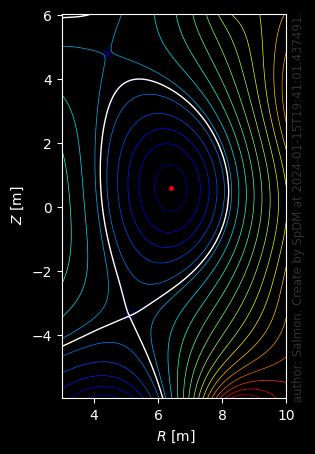

In [24]:
fig=sp_view.display(tokamak.equilibrium,format="svg")

In [25]:
tokamak.equilibrium.refresh()
tokamak.core_sources.refresh()
tokamak.core_transport.refresh()


2024-01-15 19:41:01,613 [    spdm]     INFO: Execute module fytok.plugins.equilibrium.FyEqAnalyze
2024-01-15 19:41:01,617 [    spdm]     INFO: Execute module fytok.modules.CoreSources
2024-01-15 19:41:02,442 [    spdm]     INFO: Execute module fytok.plugins.core_sources.source.dummy
2024-01-15 19:41:02,446 [    spdm]     INFO: Execute module fytok.plugins.core_sources.source.collisional_equipartition
2024-01-15 19:41:02,451 [    spdm]     INFO: Execute module fytok.plugins.core_sources.source.fusion
2024-01-15 19:41:02,455 [    spdm]     INFO: Execute module fytok.plugins.core_sources.source.radiation
2024-01-15 19:41:02,459 [    spdm]     INFO: Execute module fytok.plugins.core_sources.source.synchrotron_radiation
2024-01-15 19:41:02,461 [    spdm]     INFO: Execute module fytok.modules.CoreTransport
2024-01-15 19:41:02,467 [    spdm]     INFO: Execute module fytok.plugins.core_transport.model.dummy


In [26]:
solver = tokamak.transport_solver
solver_1d = solver.preprocess(
    time=0.0,
    # fmt:off
    initial_value={
        "psi":0.0,
        "ion/D/density":                    1.0e19,
        "ion/T/density":                    1.0e19,
        "ion/He/density":                   1.0,
        "ion/alpha/density":                1.0,

        "ion/D/temperature":                2.0e3,
        "ion/T/temperature":                2.0e3,
        "ion/He/temperature":               2.0e3,
        "electrons/temperature":            2.0e3,
    },
    boundary_value={
        "ion/D/density":                    1.3e19, 
        "ion/T/density":                    1.3e19, 
        "ion/He/density":                   1.0, 
        "ion/alpha/density":                1.0, 

        "ion/D/temperature":                200,   
        "ion/T/temperature":                200,   
        "ion/He/temperature":               200,   
        "electrons/temperature":            200,   
    },
    # fmt:on
)
solver_1d = solver.execute(solver_1d)
solver_1d = solver.postprocess(solver_1d)

2024-01-15 19:41:03,169 [    spdm]     INFO: Solve transport equations : psi  ,electrons/temperature  ,ion/T/density  ,ion/T/temperature  ,ion/D/density  ,ion/D/temperature  ,ion/He/density  ,ion/He/temperature  ,ion/alpha/density
2024-01-15 19:41:03,170 [    spdm]     INFO: Execute module fytok.plugins.transport_solver_numerics.fy_trans
   Iteration    Max residual  Max BC residual  Total nodes    Nodes added  
       1          9.55e+00       5.21e-16          128            126      
       2          1.36e+01       2.45e-10          254            252      
       3          1.19e+01       5.19e-11          506           (499)     
Number of nodes is exceeded after iteration 3. 
Maximum relative residual: 1.19e+01 
Maximum boundary residual: 5.19e-11
2024-01-15 19:41:21,224 [    spdm]    DEBUG: /home/salmon/workspace/fytok/python/fytok/plugins/transport_solver_numerics/fy_trans/fy_trans.py:753:execute: Solve BVP failed: The maximum number of mesh nodes is exceeded. , 3 iterations
2

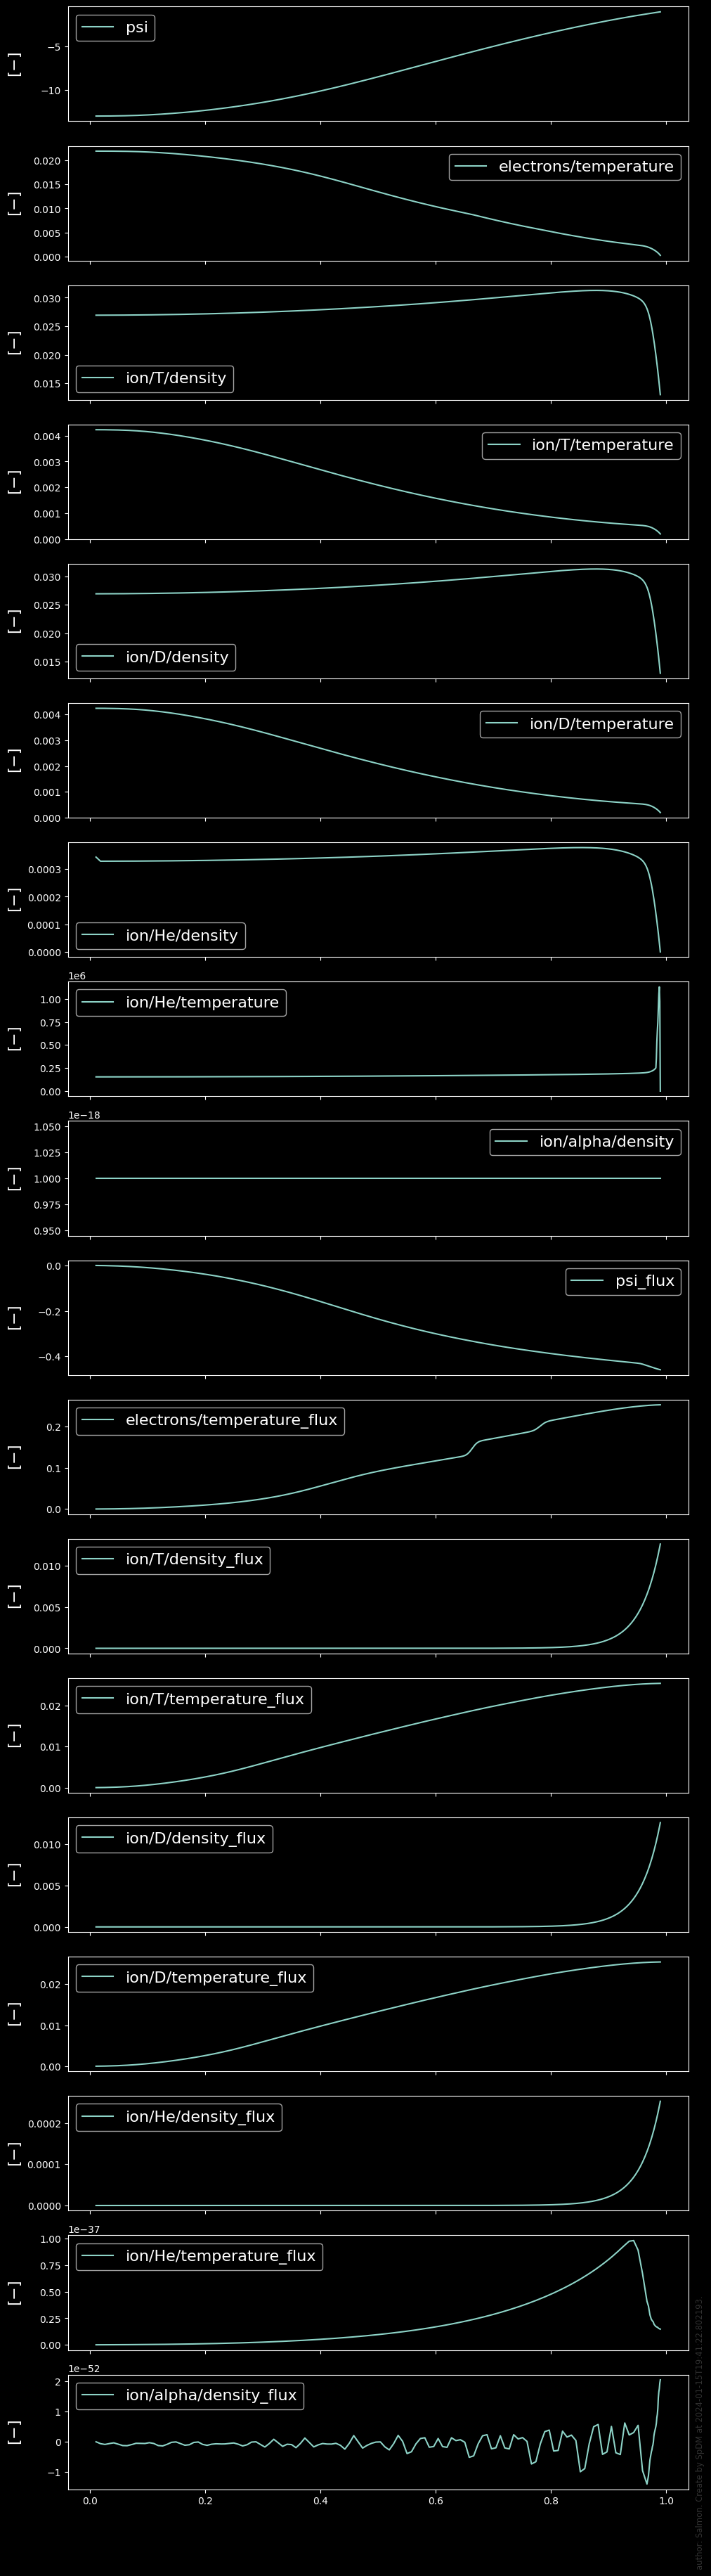

In [27]:
fig = sp_view.plot(
    solver_1d.X,
    *[(solver_1d.Y[idx * 2], equ.identifier) for idx, equ in enumerate(solver.equations)],
    *[(solver_1d.Y[idx * 2+1], f"{equ.identifier}_flux") for idx, equ in enumerate(solver.equations)],
)

In [28]:
tokamak.flush()
core_profiles_1d = tokamak.core_profiles.time_slice.current.profiles_1d

/home/salmon/workspace/fytok/python/fytok/plugins/core_sources/source/collisional_equipartition.py:60: RuntimeWarning: invalid value encountered in log
  23 - np.log(ze) - 0.5 * np.log(ne * 1.0e-6) + 1.5 * np.log(Te),


In [29]:
core_profiles_1d = tokamak.core_profiles.time_slice.current.profiles_1d

2024-01-15 19:41:28,975 [    spdm]    DEBUG: /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/fy_eq/fy_eq.py:94:__init__: Create FyEquilibriumCoordinateSystem <FyEquilibriumCoordinateSystem name='coordinate_system' />
2024-01-15 19:41:29,009 [    spdm]  WARNING: /home/salmon/workspace/fytok/python/fytok/plugins/equilibrium/fy_eq/fy_eq.py:132:__init__: Singular values are caused when psi_norm takes values of 0.0 or 1.0.! 0.0 1.0


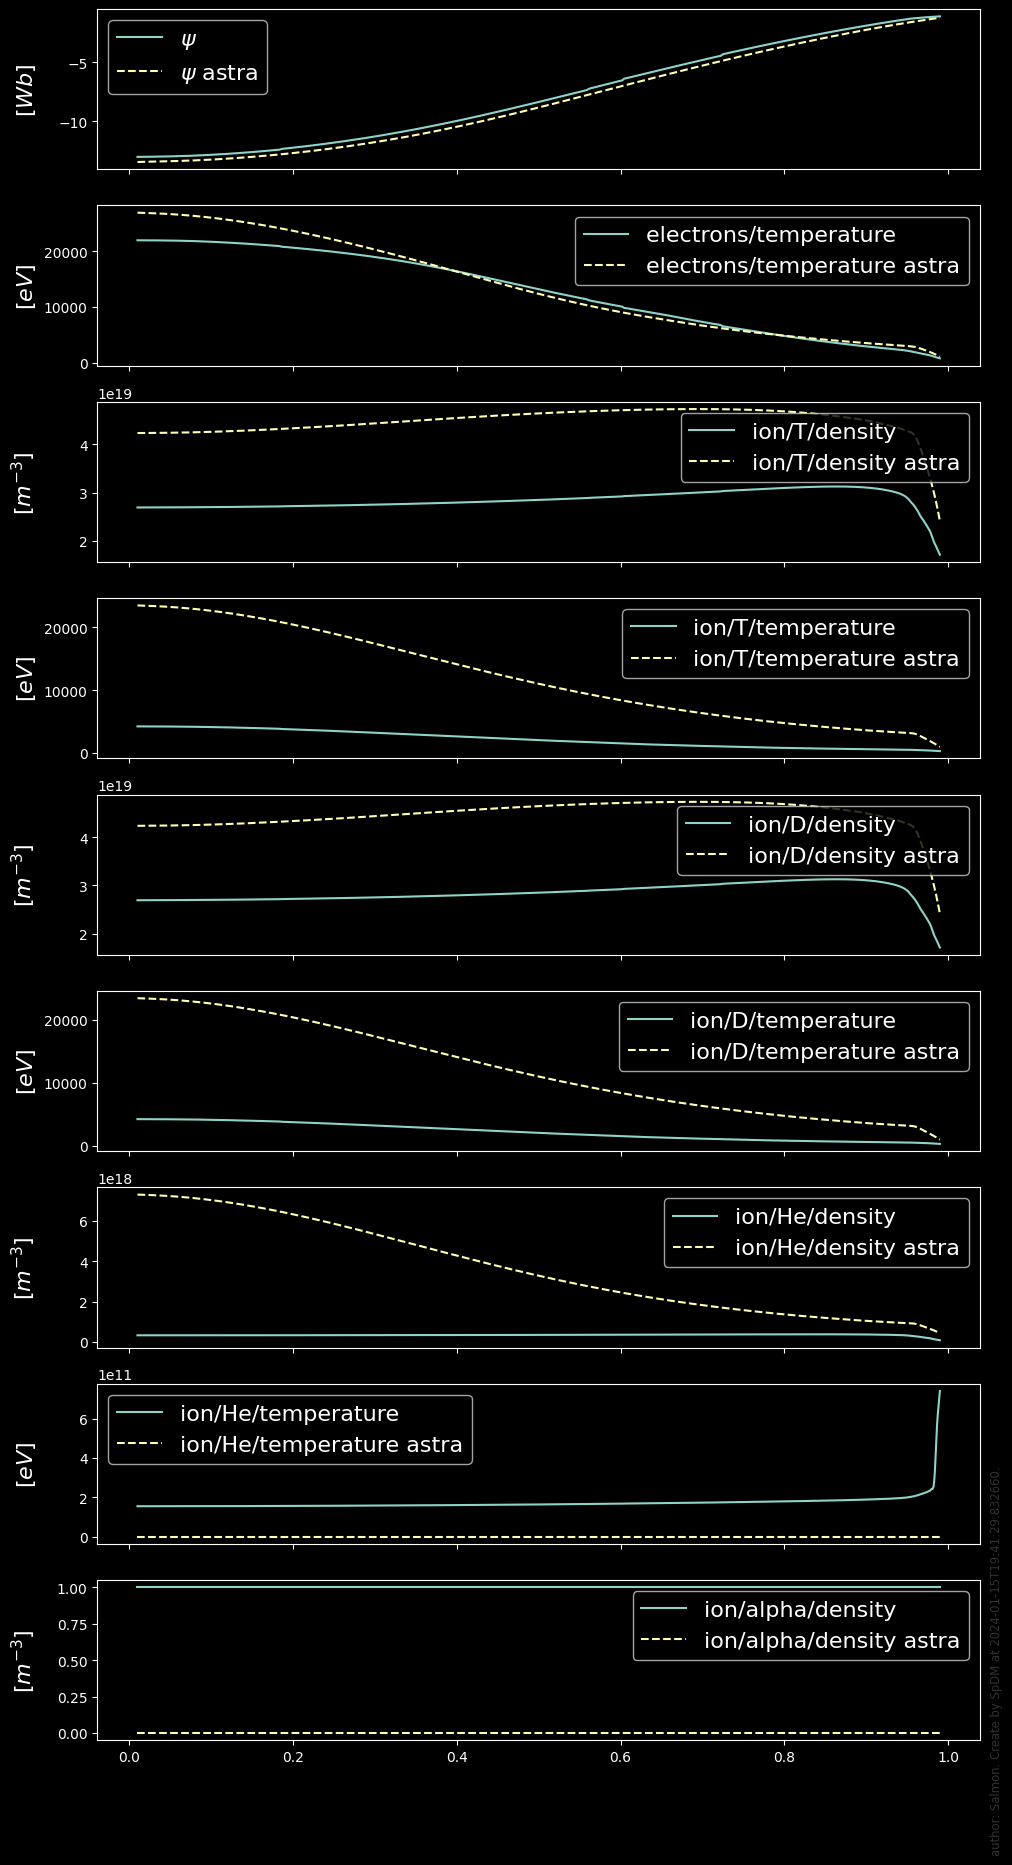

In [30]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        (core_profiles_1d.psi, r"$\psi$"),
        (
            equilibrium_astra.time_slice.current.profiles_1d.psi(solver_1d.grid.psi_norm),
            {"label": r"$\psi$ astra", "$matplotlib": {"linestyle": "dashed"}},
        ),
    ],
    *[
        [
            (Path(equ.identifier).get(core_profiles_1d, 0), f"{equ.identifier} "),
            (
                Path(equ.identifier).get(core_profiles_1d_astra, 0),
                {"label": f"{equ.identifier} astra", "$matplotlib": {"linestyle": "dashed"}},
            ),
        ]
        for equ in solver_1d.equations
        if equ.identifier != "psi"
    ],
)

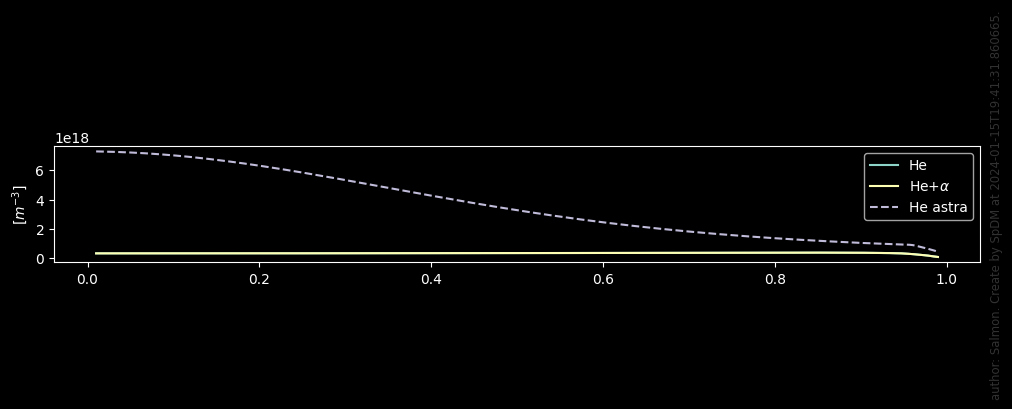

In [31]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    [
        # (core_profiles_1d.ion["alpha"].density, r"$\alpha$"),
        (core_profiles_1d.ion["He"].density, r"He"),
        (core_profiles_1d.ion["He"].density + core_profiles_1d.ion["alpha"].density, r"He+$\alpha$"),
        (core_profiles_1d_astra.ion["He"].density, {"label": f"He astra", "$matplotlib": {"linestyle": "dashed"}}),
    ],
    fontsize=10,
)

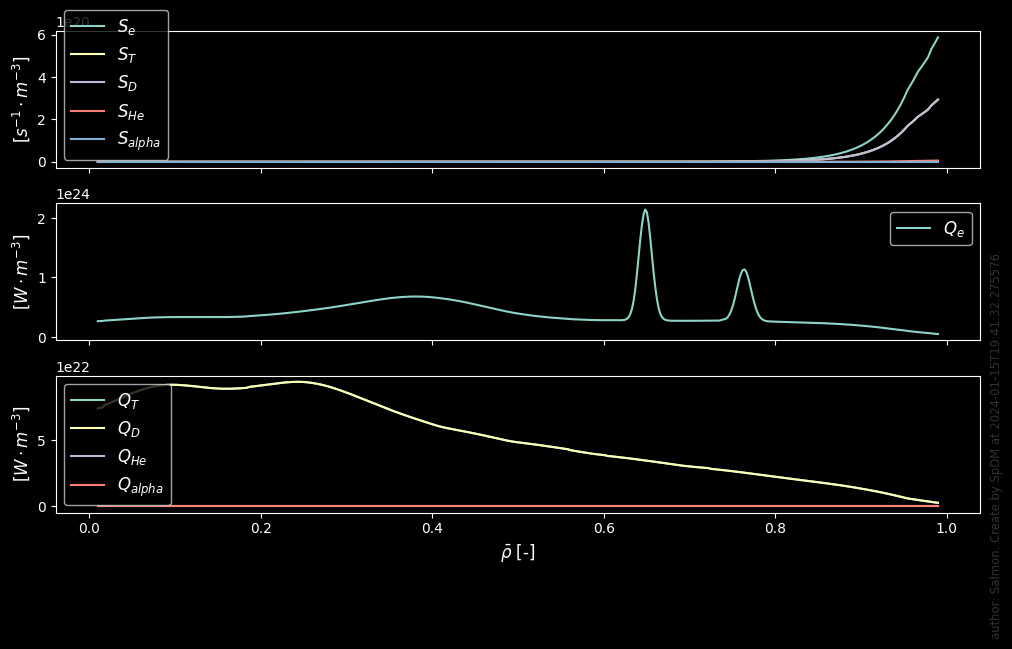

In [32]:
source_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [(source_1d.electrons.particles, r"$S_{e}$")] + [(ion.particles, rf"$S_{{{ion.label}}}$") for ion in source_1d.ion],
    [(source_1d.electrons.energy, r"$Q_{e}$")],
    [(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

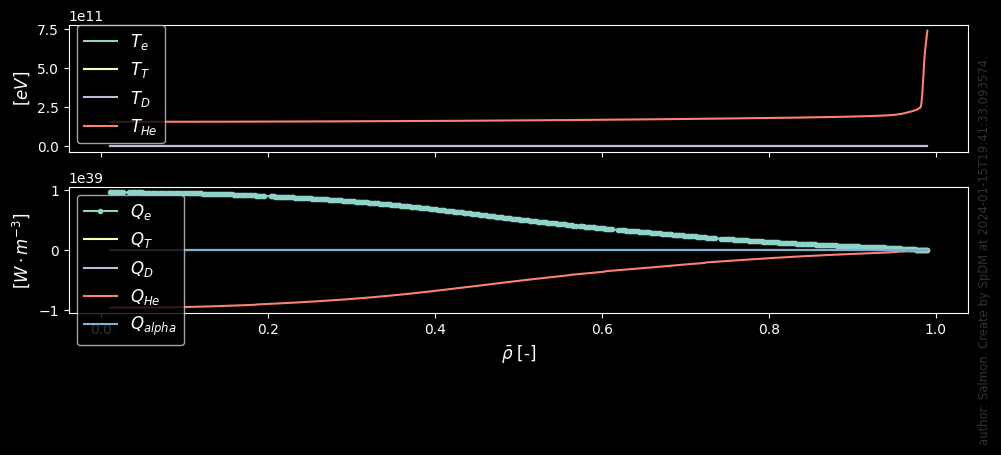

In [33]:
source_1d = tokamak.core_sources.source[1].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [
        (core_profiles_1d.electrons.temperature, r"$T_{e}$"),
        *[(ion.temperature, rf"$T_{{{ion.label}}}$") for ion in core_profiles_1d.ion],
    ],  # [(source_1d.electrons.particles, r"$S_{e}$")] + [(ion.particles, rf"$S_{{{ion.label}}}$") for ion in source_1d.ion],
    [
        (source_1d.electrons.energy, {"label": r"$Q_{e}$", "$matplotlib": {"linestyle": "-", "marker": "."}}),
        *[(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
    ],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

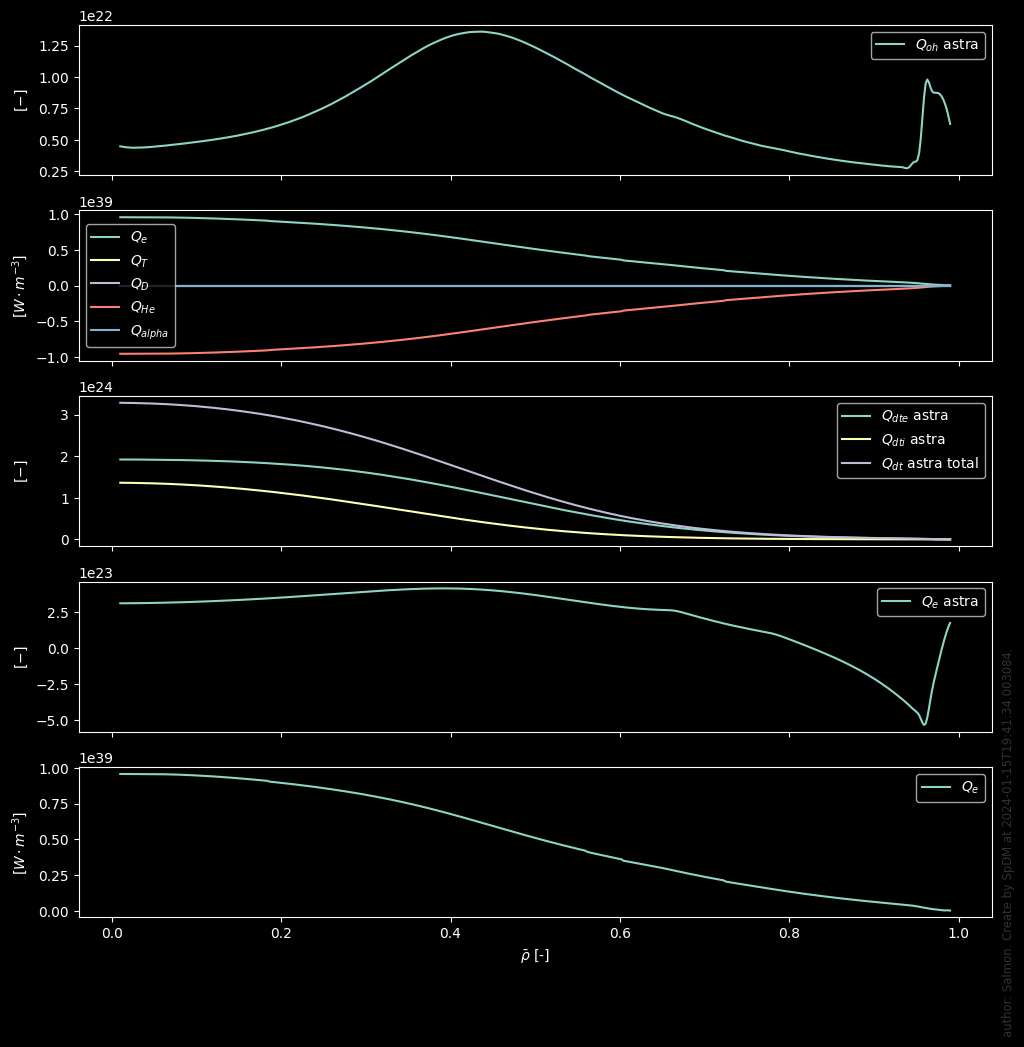

In [34]:
astra_rho_tor_norm = astra_profiles["x"].values
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    (
        Function(astra_rho_tor_norm, astra_profiles["Poh"].values * 1.0e6 / scipy.constants.electron_volt),
        r"$Q_{oh}$ astra",
    ),
    [
        (tokamak.core_sources.source[1].time_slice.current.profiles_1d.electrons.energy, r"$Q_{e}$"),
        *[
            (ion.energy, rf"$Q_{{{ion.label}}}$")
            for ion in tokamak.core_sources.source[1].time_slice.current.profiles_1d.ion
        ],
    ],
    [
        (
            Function(astra_rho_tor_norm, astra_profiles["Pdte"].values * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{dte}$ astra",
        ),
        (
            Function(astra_rho_tor_norm, astra_profiles["Pdti"].values * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{dti}$ astra",
        ),
        (
            Function(astra_rho_tor_norm, (astra_profiles["Pdt"].values) * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{dt}$ astra total",
        ),
    ],
    *[
        (
            Function(astra_rho_tor_norm, astra_profiles["Peic"].values * 1.0e6 / scipy.constants.electron_volt),
            r"$Q_{e}$ astra",
        ),
        (source_1d.electrons.energy, r"$Q_{e}$"),
    ],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=10,
)

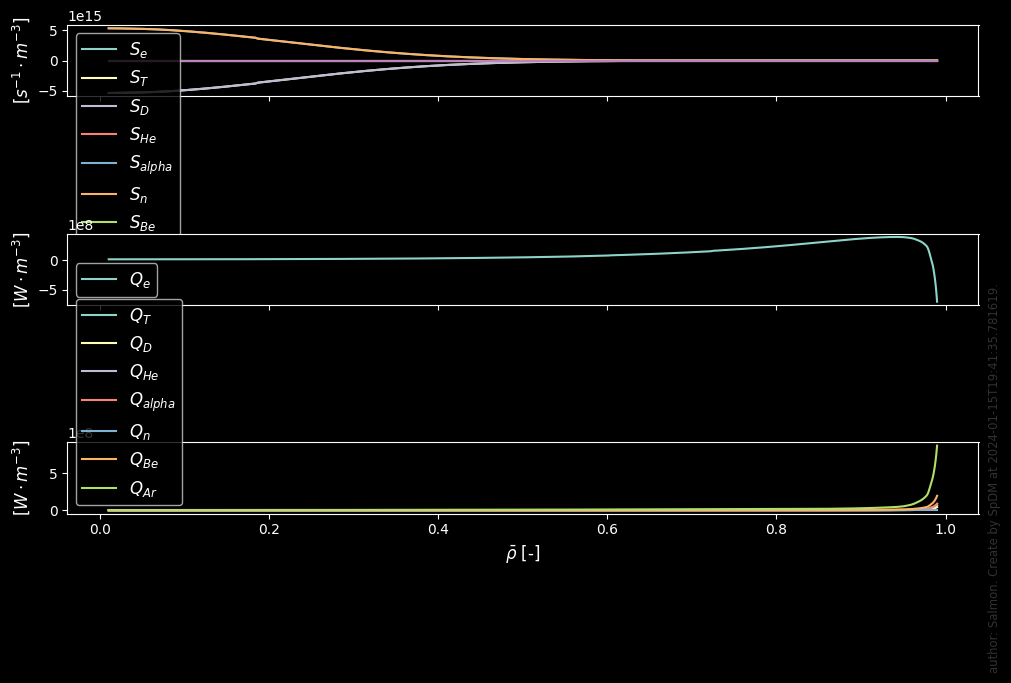

In [35]:
source_1d = tokamak.core_sources.source[2].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    [(source_1d.electrons.particles, r"$S_{e}$")] + [(ion.particles, rf"$S_{{{ion.label}}}$") for ion in source_1d.ion],
    [(source_1d.electrons.energy, r"$Q_{e}$")],
    [(ion.energy, rf"$Q_{{{ion.label}}}$") for ion in source_1d.ion],
    x_label=r"$\bar{\rho}$ [-]",
    fontsize=12,
)

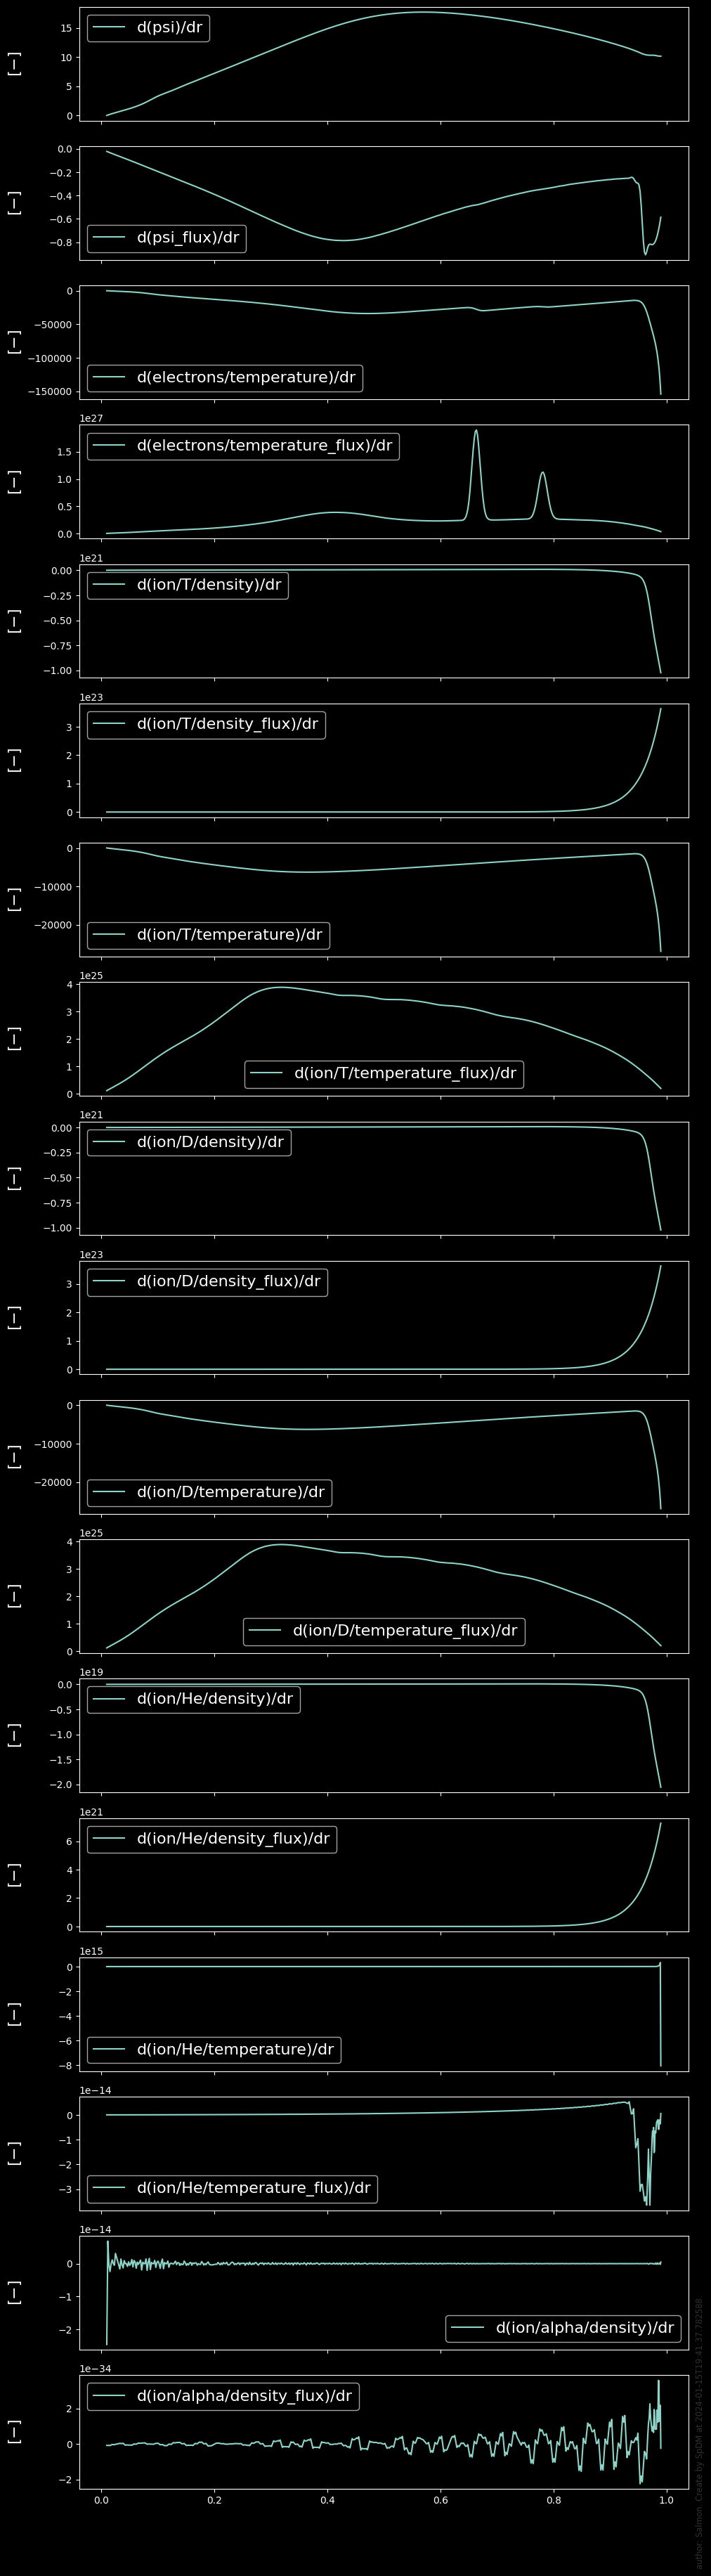

In [36]:
fig = sp_view.plot(
    solver_1d.grid.rho_tor_norm,
    *sum(
        [
            [
                # (solver_1d.Y0[2 * idx], f"d({equ.identifier})/dr"),
                # (solver_1d.Y0[2 * idx + 1], f"d({equ.identifier}_flux)/dr"),
                (equ.d_dr, f"d({equ.identifier})/dr"),
                (equ.dflux_dr, f"d({equ.identifier}_flux)/dr"),
            ]
            for idx, equ in enumerate(solver_1d.equations)
        ],
        [],
    ),
)

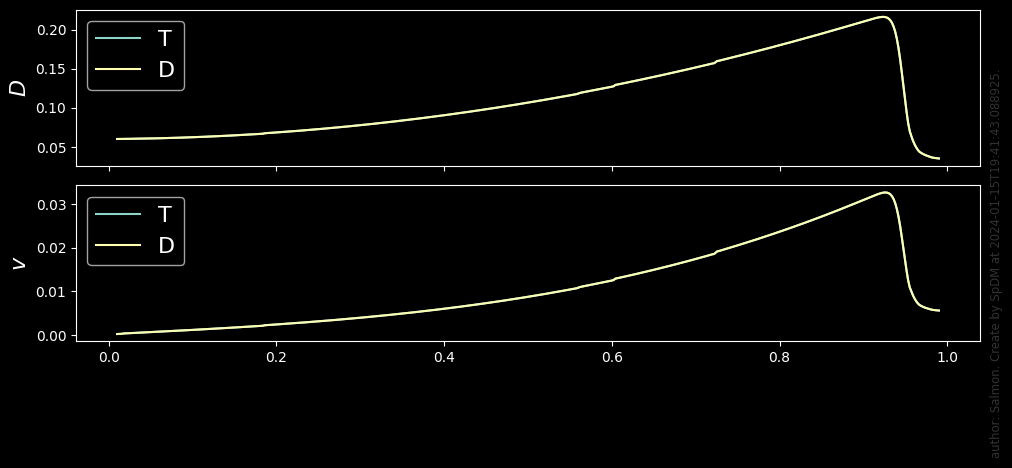

In [37]:
trans_1d = tokamak.core_transport.model[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    trans_1d.grid_d.rho_tor_norm,
    (
        [
            (trans_1d.ion[0].particles.d, trans_1d.ion[0].label),
            (trans_1d.ion[1].particles.d, trans_1d.ion[1].label),
        ],
        {"y_label": "D"},
    ),
    (
        [
            (trans_1d.ion[0].particles.v, trans_1d.ion[0].label),
            (trans_1d.ion[1].particles.v, trans_1d.ion[1].label),
        ],
        {"y_label": "v"},
    ),
)

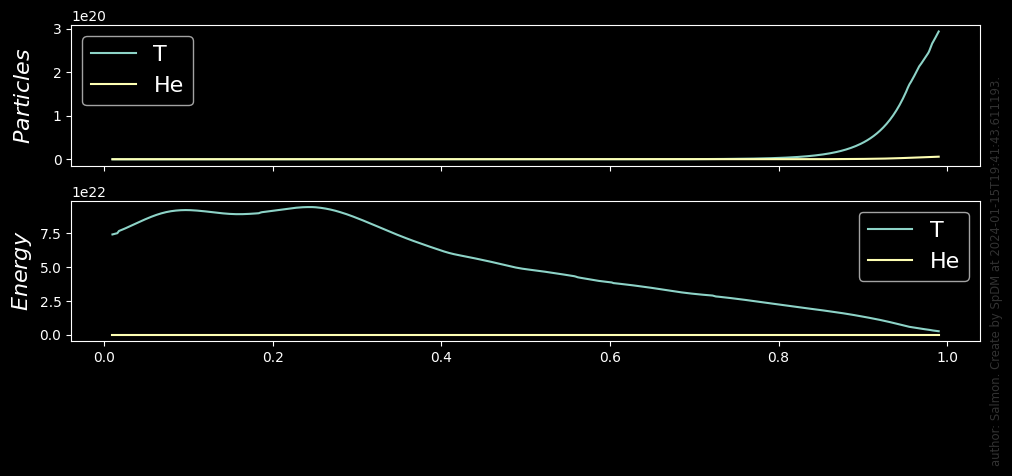

In [38]:
source_1d = tokamak.core_sources.source[0].time_slice.current.profiles_1d
fig = sp_view.plot(
    source_1d.grid.rho_tor_norm,
    (
        [
            (source_1d.ion[0].particles, source_1d.ion[0].label),
            (source_1d.ion[2].particles, source_1d.ion[2].label),
        ],
        {"y_label": "Particles"},
    ),
    (
        [
            (source_1d.ion[0].energy, source_1d.ion[0].label),
            (source_1d.ion[2].energy, source_1d.ion[2].label),
        ],
        {"y_label": "Energy"},
    ),
)